# Binary Classification

In [ ]:
from kiwigrad import MLP, Layer, Value, draw_dot
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt 
import time

In [2]:
def accuracy_val(model, X ,y_true):
    y_pred = np.array([model(X[i]).sigmoid().data for i in range(X.shape[0])]).round()
    correct_results = np.sum(y_pred == y_true)
    acc = correct_results/y_true.shape[0]
    acc = np.round(acc * 100)
    return acc

### Dataset

In [3]:
X, y = make_moons(n_samples=100, noise=0.1)
print(X.shape, type(X))
print(y.shape, type(y))

(100, 2) <class 'numpy.ndarray'>
(100,) <class 'numpy.ndarray'>


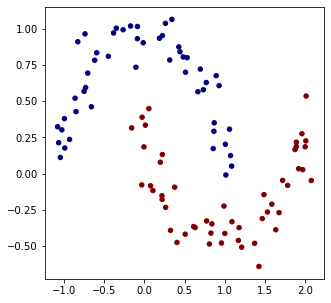

In [4]:
# visualize dataset
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')
plt.show()

### Full Batch Gradient Descent with BCE loss

In [5]:
class PotNet(MLP):
    def __init__(self):
        layers = [
            Layer(nin=2, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=16, bias=True, activation="relu"),
            Layer(nin=16, nout=1, bias=True, activation="linear")
        ]
        super().__init__(layers=layers)

model = PotNet()

In [13]:
epochs = 100 
for epoch in range(epochs): 
    operation = 0
    backpass = 0
    update = 0
    accuracy_time = 0
    forward = 0
    loss = 0
    s = time.monotonic()
    for i in range(X.shape[0]):
        s_o = time.monotonic()
        s_f = time.monotonic()
        output = model(X[i]).sigmoid()
        e_f = time.monotonic()
        t_f = e_f - s_f
        forward += t_f
        neg_output = 1-output
        target = y[i]
        s_l = time.monotonic()
        bce_loss = -(target * output.log() + (1 - target) * neg_output.log())
        e_l = time.monotonic()
        t_l = e_l - s_l
        loss += t_l
        e_o = time.monotonic()
        t_o = e_o - s_o
        operation += t_o
        s_b = time.monotonic()
        bce_loss.backward()
        e_b = time.monotonic()
        t_b = e_b - s_b
        backpass += t_b
        s_u = time.monotonic()
        for p in model.parameters():
            p.data += -0.001 * p.grad 
        e_u = time.monotonic()
        t_u = e_u - s_u
        update += t_u
        model.zero_grad()
    s_a = time.monotonic()
    acc = accuracy_val(model=model, X=X, y_true=y)
    e_a = time.monotonic()
    t_a = e_a - s_a
    accuracy_time += t_a
    e = time.monotonic()
    t = e - s
    if epoch%10 == 0:
        print(f"epoch: {epoch} |", f"loss: {bce_loss.data:.2f} |", f"accuracy: {acc} |", f"time: {t:.2f} |",f"operation: {operation:.2f} |", f"forward: {forward:.2f}", f"loss: {loss:.2f}", f"backward: {backpass:.2f} |", f"update: {update:.2f}", f"acc_time: {accuracy_time:.2f}")

epoch: 0 | loss: 0.83 | accuracy: 89.0 | time: 1.27 | operation: 0.72 | forward: 0.71 loss: 0.01 backward: 0.12 | update: 0.01 acc_time: 0.40
epoch: 10 | loss: 0.68 | accuracy: 90.0 | time: 1.27 | operation: 0.75 | forward: 0.74 loss: 0.01 backward: 0.12 | update: 0.01 acc_time: 0.39
epoch: 20 | loss: 0.66 | accuracy: 90.0 | time: 1.24 | operation: 0.73 | forward: 0.72 loss: 0.01 backward: 0.11 | update: 0.01 acc_time: 0.38
epoch: 30 | loss: 0.71 | accuracy: 90.0 | time: 1.25 | operation: 0.66 | forward: 0.65 loss: 0.01 backward: 0.11 | update: 0.01 acc_time: 0.47
epoch: 40 | loss: 0.69 | accuracy: 90.0 | time: 1.27 | operation: 0.67 | forward: 0.66 loss: 0.01 backward: 0.11 | update: 0.01 acc_time: 0.47
epoch: 50 | loss: 0.68 | accuracy: 89.0 | time: 1.26 | operation: 0.67 | forward: 0.66 loss: 0.01 backward: 0.11 | update: 0.01 acc_time: 0.46
epoch: 60 | loss: 0.61 | accuracy: 90.0 | time: 1.27 | operation: 0.74 | forward: 0.74 loss: 0.01 backward: 0.11 | update: 0.01 acc_time: 0.39


(-1.5789640090910926, 2.1710359909089076)

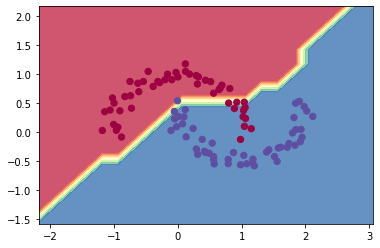

In [10]:
# visualize decision boundary
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())